## Анализ результатов A/B теста методами t-тест, U-тест, бутстрап средних
Перед вами таблица с результатами A/B-теста.  
В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.  

Описание колонок:  
value – значения метрики  
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)  

Задача  
Нужно понять, стали ли мы больше зарабатывать с пользователя или нет.  
Открытый вопрос: какой инструмент использовать (t-тест, U-тест Mann-Whitney или бутстрап)?  

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних  
2. Сравните результат между тестом и контролем по всем этим кейсам  
3. Напишите выводы, которые можно сделать на основе анализа примененных критериев.

Напишите, почему мы должны использовать тот или иной инструмент:
- каких предположений о случайной величине нужно придерживаться,
- какие условия необходимы и т.п.  

### Гипотеза
H0 - значения в группах control и treatment значимо не различаются  
H1 - значения в группах control и treatment значимо различаются
## Подготовка данных
подгружаем библиотеки, читаем данные и смотрим на их состояние

In [47]:
import numpy as np
import pandas as pd

import scipy.stats
import pingouin
import statsmodels.api as sm

import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (16,5)})

In [2]:
data = pd.read_csv('hw_bootstrap.csv', sep=';')
data.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   value              1000 non-null   object
 2   experimentVariant  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [4]:
data.nunique()

Unnamed: 0           1000
value                 505
experimentVariant       2
dtype: int64

In [5]:
data.experimentVariant.unique()

array(['Control', 'Treatment'], dtype=object)

удалим дублирующий индексы столбец, а значения поменяем со строковых на непрерывные  
разделим данные на две группы: control (контроль) и treatment (тест)

In [6]:
del data['Unnamed: 0']
data['value'] = data.value.str.replace(',', '.').astype('float')

control = data[data.experimentVariant == 'Control'].value
treatment = data[data.experimentVariant == 'Treatment'].value

посмотрим на описательные статистики

In [7]:
control.describe()

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

In [8]:
treatment.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

видна значительная разница: mean, std, max  
проверяем на нормальность распределений

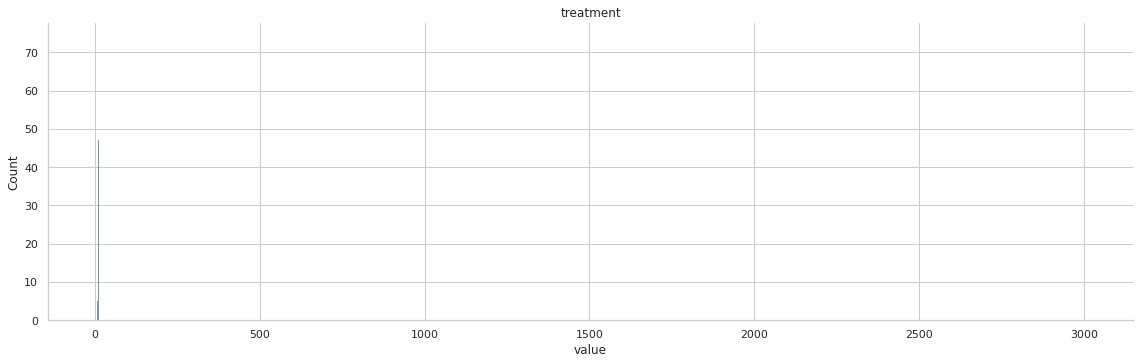

In [9]:
sns.displot(treatment, aspect=16/5).set(title='treatment');

🤔 данные в treatment выглядят не очень, похоже на наличие больших выбросов.  
Попробуем применить логарифм.

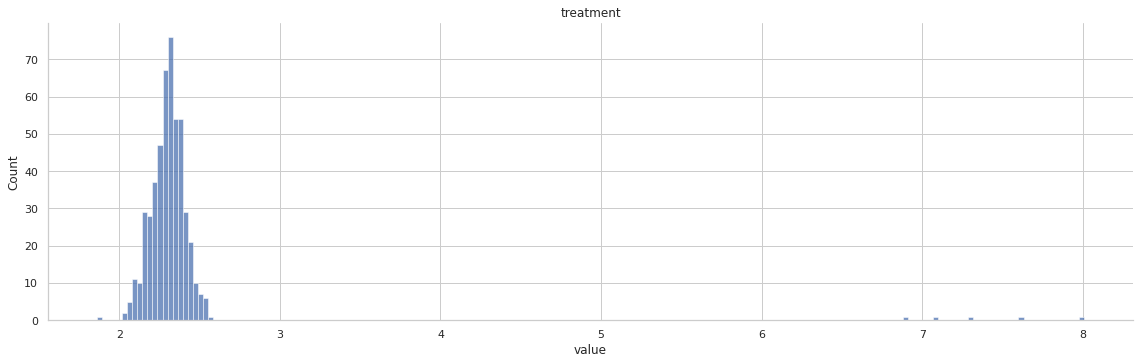

In [10]:
sns.displot(np.log(treatment), aspect=16/5).set(title='treatment');

Выглядит немного лучше, но выбросы остались.  
Посмотрим на сами значения.

In [11]:
treatment.sort_values().tail(10)

719      12.598569
863      12.663784
794      12.728285
695      12.817541
671      13.130346
995    1000.000000
996    1200.000000
997    1500.000000
998    2000.000000
999    3000.000000
Name: value, dtype: float64

In [12]:
emissions = data[(data.experimentVariant == 'Treatment') & (data.value > 999)]
normal = data[(data.experimentVariant == 'Treatment') & (data.value < 999)]
percent = round(emissions.count() / normal.count()*100).value
difference = int(emissions.mean() / normal.mean())
print(f'в группе treatment около {percent}% выбросов, в {difference} раз превыщающие среднее значение остальных данных')

в группе treatment около 1.0% выбросов, в 173 раз превыщающие среднее значение остальных данных


Предварительный вывод: эти выбросы похожи на ошибку в данных.  
🙄 что если мы избавимся от них и снова проверим распределение?

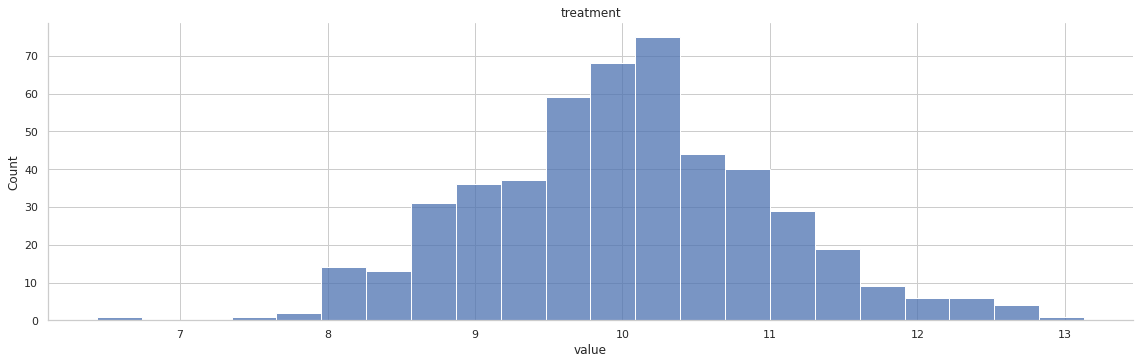

In [13]:
treatment = data[(data.experimentVariant == 'Treatment') & (data.value < 999)].value
sns.displot(treatment, aspect=16/5).set(title='treatment');

График распределения treatment теперь выглядит неплохо.  
Время посмотреть как выглядит control

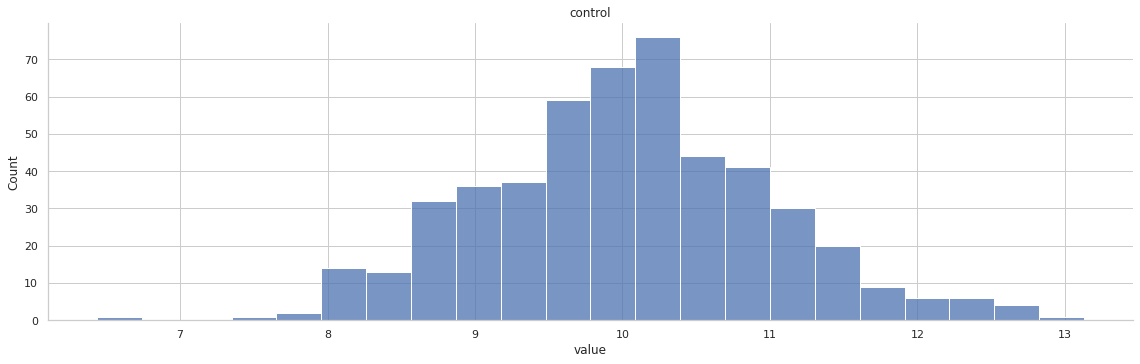

In [14]:
sns.displot(control, aspect=16/5).set(title='control');

😲 распределение control выглядит очень похоже

In [15]:
data_graph = data[data.value < 999]

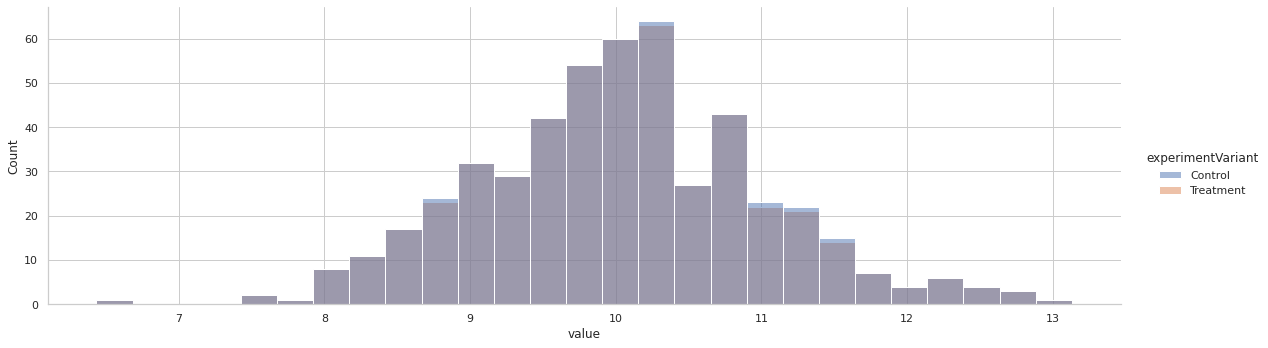

In [16]:
sns.displot(data=data_graph, x='value', hue='experimentVariant', aspect=16/5);

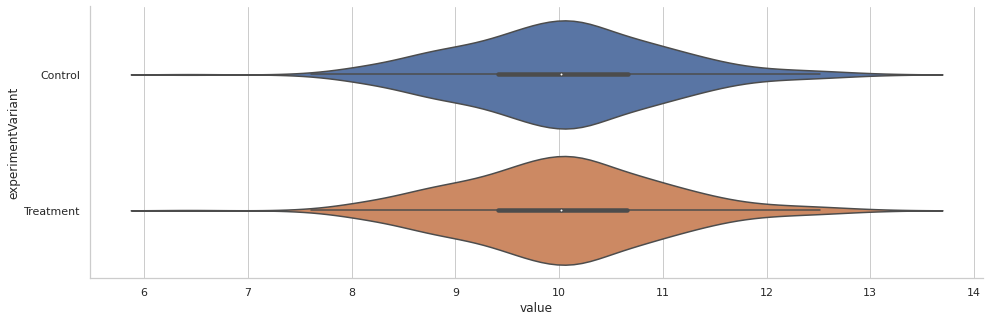

In [17]:
sns.violinplot(data=data_graph, x='value', y='experimentVariant', aspect=16/5)
sns.despine()

распределения выглядят хорошо  
почсмотрим на выбросы через qqplot

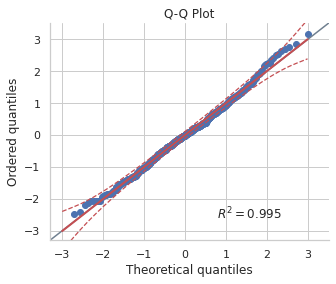

In [18]:
pingouin.qqplot(control)
sns.despine()

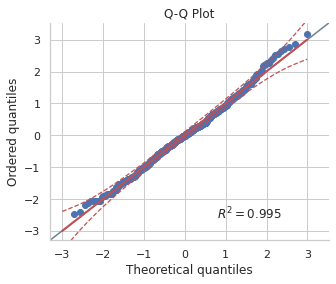

In [19]:
pingouin.qqplot(treatment)
sns.despine()

критичных выбросов на qqplot не выявлено  
посмотрим на размеры выборок

In [20]:
print('control:', len(control), '\ntreatment:', len(treatment))

control: 500 
treatment: 495


для корректного сравнения сделаем размеры выборок одинаковыми

In [21]:
for i in range(5):
    control = control.drop(index=random.randint(0, len(control)))

теперь можно сравнивать описательные статистики снова

In [22]:
treatment.describe()

count    495.000000
mean      10.021716
std        0.978140
min        6.436541
25%        9.407997
50%       10.015492
75%       10.652341
max       13.130346
Name: value, dtype: float64

In [23]:
control.describe()

count    495.000000
mean      10.024733
std        0.978791
min        6.436541
25%        9.407997
50%       10.020862
75%       10.658725
max       13.130346
Name: value, dtype: float64

группы действительно стали очень похожи  
Теперь мы должны провести тесты на нормальность и дисперсию  
### тест Шапиро-Уилка (на нормальность распределений)
чувствителен на выбросы

In [24]:
pingouin.normality(control, method='shapiro')

,W,pval,normal
value,0.995853,0.218294,True


In [25]:
pingouin.normality(treatment, method='shapiro')

,W,pval,normal
value,0.995552,0.171882,True


### Normal тест (на нормальность распределений)

In [26]:
pingouin.normality(control, method='normaltest')

,W,pval,normal
value,2.937008,0.23027,True


In [27]:
pingouin.normality(treatment, method='normaltest')

,W,pval,normal
value,3.426451,0.180283,True


по тесту Шапиро-Уилка и NormalTest control и treatment показывает pvalue>0.05, зто означает что распределения выглядят нормально  
### тест Левена (различия в дисперсиях)

In [28]:
scipy.stats.levene(control, treatment)

LeveneResult(statistic=0.002250322158899314, pvalue=0.9621740805399766)

тест Левена pvalue>0.05, оставляем H0 дисперсии внутри групп примерно одинаковы
## Сравнение данных
### t-test
(чувствителен к выбросам)
требования: 
- распределение в группах должно быть нормальным
- примерно одинаковая дисперсия внутри групп

мы прошли эти тесты в предыдущем степе и теперь можем применить ttest

In [29]:
ttest = scipy.stats.ttest_ind(control, treatment)
ttest

Ttest_indResult(statistic=0.048504365219401165, pvalue=0.9613240885856391)

pvalue>0.05, мы принимаем H0 и делаем вывод, что средние значения группах значимо не различаются.  
### тест Манна-Уитни
ранговый тест проверки нормальности распределения, менее чувствителен к выбросам

In [30]:
mann = scipy.stats.mannwhitneyu(control, treatment)
mann

MannwhitneyuResult(statistic=122861.0, pvalue=0.9383354549868903)

Поскольку p-значение>0.05, мы принимаем H0
### Бутстрап средних

In [31]:
# объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootst(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = scipy.stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = scipy.stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    return {"boot_data": boot_data, "quants": quants, "p_value": p_value}

In [32]:
# отображение графика bootstrap
def bootstrap_graph(pd_boot_data, quants):
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data, bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

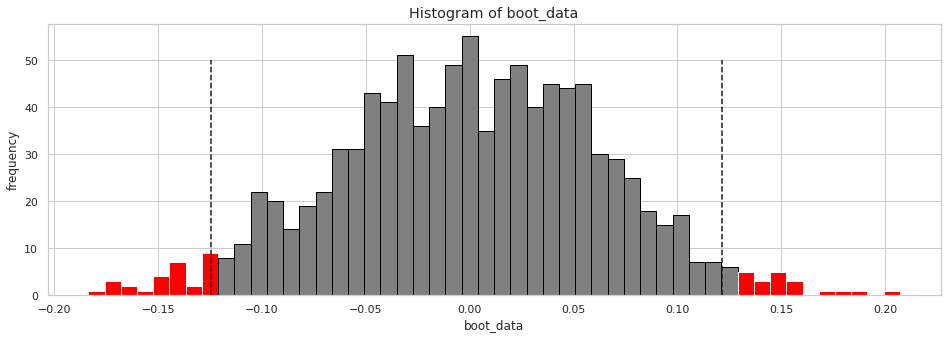

p_value: 0.9975352711500095


In [33]:
bootstrap = get_bootst(control, treatment) # в результате хранится разница двух распределений, ДИ и pvalue
bootstrap_graph(bootstrap['boot_data'], bootstrap['quants'])
print('p_value:', bootstrap['p_value'])

мы наблюдаем что 0 находится в доверительном интервале, p-value>0.05  
Мы оставляем H0, группы не различаются
## Сводные таблицы

In [34]:
pd.DataFrame(columns=['param', 'control', 'treatment', 'difference'],
             data=[['mean', np.mean(control), np.mean(treatment), np.mean(treatment)/np.mean(control)],
                   ['std', np.std(control), np.std(treatment), np.std(treatment)/np.std(control)],
                   ['sum', np.sum(control), np.sum(treatment), np.sum(treatment)/np.sum(control)],])

,param,control,treatment,difference
0,mean,10.024733,10.021716,0.999699
1,std,0.977802,0.977151,0.999334
2,sum,4962.242818,4960.749528,0.999699


In [35]:
pd.DataFrame(columns=['test', 'pvalue'],data=[['t-test', ttest[1]], ['mann', mann[1]], \
                                              ['bootstrap', bootstrap['p_value']]])

,test,pvalue
0,t-test,0.961324
1,mann,0.938335
2,bootstrap,0.997535


## Заключение
Перед исследованием был поставлен вопрос:  
"стали ли мы больше зарабатывать с пользователя или нет?"

Вероятно нам нужно было выяснить изменилось ли стандартное отклонение, среднее значение между тестовой и контрольной группой и провести тесты:


Мы сформулировали гипотезу где:  
H0 - значения в группах control и treatment значимо не различаются  
H1 - значения в группах control и treatment значимо различаются

В ходе исследования мы нормализовали данные и провели тесты.

В группе treatment было обнаружено около 1% выбросов, в 173 раза превыщающие среднее значение (подробнее в рекомендациях).  
Мы предполагаем что это ошибочные данные, и для корректного сравнения было принято решение исключить их из выборки как незначительные относительно остальных 99%.

Также для прохождения t-test нам необходимо было соблюсти условия и пройти тесты:
- распределение в группах должно быть нормальным (тест Шапиро-Уилка, NormalTest), 
- примерно одинаковая дисперсия внутри групп (тест Левена)

Мы посчитали p-value наших групп с помощью t-test, тест Манна-Уитни, Бутстрап тест
### Вывод
По результатам тестов (t-test, тест Манна-Уитни, Бутстрап тест) p-value>0.05  
Это означает что у нас нет оснований отклонить H0 нулевую гипотезу, группы control и treatment значимо не различаются.  

**Среднее значение чека значимо не различаются, зарабатывать больше не стали.**
### Рекомендации
изучить значения выбросов, предположительно они могут иметь характер ошибки в данных

# Альтернативное решение
Рассмотрим ситуацию:
- после первого анализа нам сообщили что значения выбросов в treatment группе являются статистически значимыми (не являются ошибкой)  
тогда:  
- необходимо провести сравнение при наличии этих значений.

In [36]:
control = data[data.experimentVariant == 'Control'].value
treatment = data[data.experimentVariant == 'Treatment'].value

### тест Шапиро-Уилка (на нормальность распределений)
чувствителен на выбросы

In [37]:
pingouin.normality(control, method='shapiro')

,W,pval,normal
value,0.995925,0.224164,True


In [38]:
pingouin.normality(treatment, method='shapiro')

,W,pval,normal
value,0.070389,1.093013e-43,False


### Normal тест (на нормальность распределений)

In [39]:
pingouin.normality(control, method='normaltest')

,W,pval,normal
value,2.943459,0.229528,True


In [40]:
pingouin.normality(treatment, method='normaltest')

,W,pval,normal
value,929.515767,1.439514e-202,False


по тесту Шапиро-Уилка и NormalTest control показывает pvalue>0.05, зто означает что распределения выглядят нормально  
но в группе treatment даже NormalTest показывает pvalue<0.05 - распределение не нормальное, у нас есть ограничения в использовании t-test
### тест Левена (различия в дисперсиях)

In [41]:
scipy.stats.levene(control, treatment)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

тест Левена pvalue<0.05, отвергаем H0, дисперсии внутри групп различаются
## Сравнение данных
### t-test
в силу того что t-test чувствителен к выбросам, а требования к нормальному распределению и примерно одинаковая дисперсии не соблюдены мы не можем корректно применить t-test

In [42]:
ttest = scipy.stats.ttest_ind(control, treatment)
ttest

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

pvalue<0.05, мы отклоняем H0 и делаем вывод, что средние значения группах различаются.  
### тест Манна-Уитни
ранговый тест проверки нормальности распределения, менее чувствителен к выбросам

In [43]:
mann = scipy.stats.mannwhitneyu(control, treatment)
mann

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

в отличии от t-test тест Манна-Уитни ожидаемо показал p-значение>0.05, мы принимаем H0
### Бутстрап средних

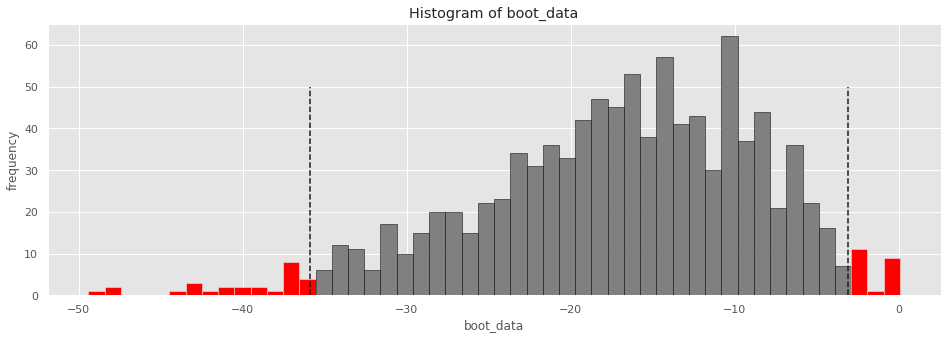

p_value: 0.04636929880514311


In [44]:
bootstrap = get_bootst(control, treatment) # в результате хранится разница двух распределений, ДИ и pvalue
bootstrap_graph(bootstrap['boot_data'], bootstrap['quants'])
print('p_value:', bootstrap['p_value'])

мы наблюдаем что 0 не находится в доверительном интервале, p-value<0.05  
Мы отклоняем H0, группы существенно различаются
## Сводные таблицы

In [45]:
pd.DataFrame(columns=['param', 'control', 'treatment', 'difference'],
             data=[['mean', np.mean(control), np.mean(treatment), np.mean(treatment)/np.mean(control)],
                   ['std', np.std(control), np.std(treatment), np.std(treatment)/np.std(control)],
                   ['sum', np.sum(control), np.sum(treatment), np.sum(treatment)/np.sum(control)],])

,param,control,treatment,difference
0,mean,10.026867,27.321499,2.724829
1,std,0.978398,186.370361,190.485316
2,sum,5013.433267,13660.749528,2.724829


In [46]:
pd.DataFrame(columns=['test', 'pvalue'],data=[['t-test', ttest[1]], ['mann', mann[1]], \
                                              ['bootstrap', bootstrap['p_value']]])

,test,pvalue
0,t-test,0.038438
1,mann,0.859215
2,bootstrap,0.046369


## Заключение 2
Перед исследованием был поставлен вопрос:  
"стали ли мы больше зарабатывать с пользователя или нет?"

Мы сформулировали гипотезу где:  
H0 - значения в группах control и treatment значимо не различаются  
H1 - значения в группах control и treatment значимо различаются

В группе treatment было обнаружено около 1% выбросов, более 170 раз превыщающие среднее значение.  

Мы пробовали но не стали использовать приведение к логарифму в качестве результатов, хотя тестирование проводилось, и результаты показали:
- приведение данных к логорифму на графике показало видимый эффект улучшения распределения, были близкие показатели средних значений и стандартных отклонений. 
- но такие данные даже у группы control не прошли через тест Шапиро-Уилка и Normaltest
- при этом результаты логорифмированных данных не показали существенных различий в результатах на (t-test, тест Манна-Уитни, Бутстрап тест) в сравнении с нелогорифмированными 

t-test был проведён с нарушениями:
- распределение в группах не было нормальным (тест Шапиро-Уилка, NormalTest пройден только у группы control), 
- дисперсия внутри групп различается (тест Левена не пройден)

Мы посчитали p-value наших групп с помощью t-test, тест Манна-Уитни, Бутстрап тест

Стандартное отклонение и среднее значение между тестовой и контрольной группой различаются.
t-test и Бутстрап тест - нашли значимые различия, тест Манна-Уитни - не значительны  

### Вывод
Отвечая на вопрос: "стали ли мы больше зарабатывать с пользователя или нет?":  

**Среднее значение чека действительно стало больше в 2,7 раза в общей совокупности за счёт 1% заказов превышающих среднее значение чека в 170 раз.** 

**При этом основываясь на предыдущем заключении мы выяснили что остальные 99% данных из treatment существенно от группы control не отличаются.**